Tennis_Analysis

In [1]:
!pip install pymc

In [2]:
# Import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pymc as pm
from scipy import stats
import seaborn as sns
import arviz as az

# Trying to connect to the data source "https://github.com/JeffSackmann/tennis_atp"
import requests
# The request library is a popular HTTP library for making requests in Python. 
# It is designed to make HTTP requests easy and powerful, with methods for making HTTP requests 
# like GET, POST, PUT, DELETE, and more. 
# The library also includes methods for handling cookies, redirects, and sessions, # and supports forms and file uploads. 
# It is widely used in web scraping, web development, and other applications that need to interact with APIs or websites.

import re 
# This module provides regular expression matching operations similar to those found in Perl.
# https://docs.python.org/3/library/re.html

# The G Level Grand Slam games: 

The four Grand Slam tournaments are :</br>
1. Australian Open in January, played on hard courts.</br>
2. French Open from late May to early June, played on clay. </br>
3. Wimbledon in late June to early July, played on grass.</br>
4. US Open in August–September, played on hard courts.</br>

Each of these tournaments go on for about 2 weeks.</br>

Wimbledon is the oldest tournament, founded in 1877, followed by the US in 1881, the French in 1891, and the Australian in 1905, but it was not until 1925 that all four were held as officially sanctioned majors.   
https://en.wikipedia.org/wiki/Grand_Slam_(tennis)   


The Grand Slam level games are recorded as "G" level in the database, making it easy for us to filter out all the Grand Slam games from the raw records of all games.

# <span style="color:#ff0000;font-family">Part 1. Exploring the data:</span> 

In [3]:
# Try Read the data from year 2023, of men's single games
url_atp_matches_2023="https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2023.csv"
df_single_2023 = pd.read_csv(url_atp_matches_2023)

In [4]:
# Displaying the first few rows of the 'atp_matches_2023.csv' DataFrame
df_single_2023.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2023-9900,United Cup,Hard,18,A,20230102,300,126203,3.0,NaN,...,62.0,47.0,15.0,12.0,9.0,9.0,9.0,3355.0,16.0,2375.0
1,2023-9900,United Cup,Hard,18,A,20230102,299,126207,NaN,NaN,...,12.0,8.0,3.0,4.0,1.0,3.0,19.0,2000.0,23.0,1865.0
2,2023-9900,United Cup,Hard,18,A,20230102,296,126203,3.0,NaN,...,62.0,51.0,7.0,12.0,2.0,2.0,9.0,3355.0,10.0,2905.0
3,2023-9900,United Cup,Hard,18,A,20230102,295,126207,NaN,NaN,...,41.0,26.0,12.0,9.0,6.0,9.0,19.0,2000.0,245.0,220.0
4,2023-9900,United Cup,Hard,18,A,20230102,292,126774,1.0,NaN,...,58.0,48.0,18.0,16.0,1.0,2.0,4.0,5550.0,16.0,2375.0


In [5]:
# We focus on grand slam games, where "tourney_level" is "G"
df_single_G_2023 = df_single_2023.loc[df_single_2023['tourney_level']=='G',:]
# We can see the names of grand slam games:
df_single_G_2023.groupby('tourney_name').count()

,tourney_id,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
tourney_name,,,,,,,,,,,,,,,,,,,,,
Australian Open,127,127,127,127,127,127,127,69,15,127,...,127,127,127,127,127,127,126,126,125,125
Roland Garros,127,127,127,127,127,127,127,68,16,127,...,126,126,126,126,126,126,127,127,127,127
Us Open,127,127,127,127,127,127,127,63,21,127,...,127,127,127,127,127,127,127,127,126,126
Wimbledon,127,127,127,127,127,127,127,65,13,127,...,127,127,127,127,127,127,127,127,127,127


And it is evident that all four grand slam games were played in 2023.
In order to eliminate 127 players and determine the winner, each grand slam game consists of 127 matches.

In [6]:
df_single_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          2956 non-null   object 
 1   tourney_name        2956 non-null   object 
 2   surface             2899 non-null   object 
 3   draw_size           2956 non-null   int64  
 4   tourney_level       2956 non-null   object 
 5   tourney_date        2956 non-null   int64  
 6   match_num           2956 non-null   int64  
 7   winner_id           2956 non-null   int64  
 8   winner_seed         1235 non-null   float64
 9   winner_entry        473 non-null    object 
 10  winner_name         2956 non-null   object 
 11  winner_hand         2956 non-null   object 
 12  winner_ht           2756 non-null   float64
 13  winner_ioc          2956 non-null   object 
 14  winner_age          2954 non-null   float64
 15  loser_id            2956 non-null   int64  
 16  loser_

### The database:  


ATP Tennis Rankings, Results, and Stats  

This contains my master ATP player file, historical rankings, results, and match stats.  


Here is the meaning of the columns in the database of tennis games:

    tourney_id - The unique identifier for the tournament.
    tourney_name - The name of the tournament.
    surface - The surface of the court where the match was played.
    draw_size - The number of players in the tournament.
    tourney_level - The level of the tournament, such as Grand Slam, ATP 1000, or ATP 250.
    tourney_date - The date of the tournament.
    match_num - The number of the match in the tournament.
    winner_id - The unique identifier for the winner of the match.
    winner_seed - The seed of the winner of the match.
    winner_entry - The entry number of the winner of the match.
    winner_name - The name of the winner of the match.
    winner_hand - The dominant hand of the winner of the match.
    winner_ht - The height of the winner of the match.
    winner_ioc - The International Olympic Committee (IOC) code of the winner of the match.
    winner_age - The age of the winner of the match.
    loser_id - The unique identifier for the loser of the match.
    loser_seed - The seed of the loser of the match.
    loser_entry - The entry number of the loser of the match.
    loser_name - The name of the loser of the match.
    loser_hand - The dominant hand of the loser of the match.
    loser_ht - The height of the loser of the match.
    loser_ioc - The International Olympic Committee (IOC) code of the loser of the match.
    loser_age - The age of the loser of the match.
    score - The score of the match.
    best_of - The best-of format of the match, such as best-of-three or best-of-five.
    round - The round of the tournament in which the match was played.
    minutes - The duration of the match in minutes.
    w_ace - The number of aces served by the winner of the match.
    w_df - The number of double faults served by the winner of the match.
    w_svpt - The number of service points played by the winner of the match.
    w_1stIn - The number of first serves in by the winner of the match.
    w_1stWon - The number of first serves won by the winner of the match.
    w_2ndWon - The number of second serves won by the winner of the match.
    w_SvGms - The number of service games won by the winner of the match.
    w_bpSaved - The number of break points saved by the winner of the match.
    w_bpFaced - The number of break points faced by the winner of the match.
    l_ace - The number of aces served by the loser of the match.
    l_df - The number of double faults served by the loser of the match.
    l_svpt - The number of service points played by the loser of the match.
    l_1stIn - The number of first serves in by the loser of the match.
    l_1stWon - The number of first serves won by the loser of the match.
    l_2ndWon - The number of second serves won by the loser of the match.
    l_SvGms - The number of service games won by the loser of the match.
    l_bpSaved - The number of break points saved by the loser of the match.
    l_bpFaced - The number of break points faced by the loser of the match.
    winner_rank - The ranking of the winner of the match.
    winner_rank_points - The number of ranking points earned by the winner of the match.
    loser_rank - The ranking of the loser of the match.
    loser_rank_points - The number of ranking points earned by the loser of the match.

Reference here:</br>
A Data Model to Track Tennis Tournaments</br>
https://vertabelo.com/blog/a-data-model-to-track-tennis-tournaments/</br>
JeffSackmann/tennis_atp/matches_data_dictionary.txt</br>
https://github.com/JeffSackmann/tennis_atp/blob/master/matches_data_dictionary.txt</br>

In [7]:
# From the single game data, get the count of games won by the players
# For pandas dataframe, we can use df.loc[] method to generate a new selected df.
# usage: df.loc[dim1, dim2,...] 
# for each dimension, we can use a boolean list, such as "df['keyName']=='keyValue'" or a truncating tool ":" to specify the selection
df_wins=df_single_2023.loc[df_single_2023['tourney_level']=='G',:].groupby(['winner_name'])[['winner_age',]].count()
# change the colume names
df_wins.columns=['win_count']
# change the index colume names
df_wins.index.rename('player_name',inplace=True)
df_wins
#there are 132 players who won at least one "G" level grand slam games in 2023

,win_count
player_name,
Adrian Mannarino,4
Alejandro Davidovich Fokina,7
Aleksandar Vukic,1
Alex De Minaur,8
Alex Michelsen,1
...,...
Yibing Wu,1
Yoshihito Nishioka,6
Yosuke Watanuki,2


In [8]:
# From the single game data, get the count of games lost by the players
df_loss=df_single_2023.loc[df_single_2023['tourney_level']=='G',['loser_name','tourney_id',]].groupby(['loser_name'])[['tourney_id',]].count()
# change the colume names
df_loss.columns=['los_count']
# change the index colume names
df_loss.index.rename('player_name',inplace=True)
df_loss

# and there are 192 players who lost at least one game in the grand slams in 2023

,los_count
player_name,
Adrian Mannarino,4
Albert Ramos,4
Alejandro Davidovich Fokina,4
Aleksandar Kovacevic,1
Aleksandar Vukic,3
...,...
Yosuke Watanuki,3
Yu Hsiou Hsu,2
Zachary Svajda,1


In [9]:
# merge the 2 DataFrames (wins and loss), 
# and know that there are some players who had only lost games without any victories, making the df_loss longer than df_wins
# fill the vacancy of winning spot of these players with 0
df_G_players=pd.concat([df_wins,df_loss],axis=1,join='outer').fillna(0)
# and then find the sum of win and los and add to the 3rd column
df_G_players=pd.concat([df_G_players,df_G_players.sum(axis=1)],axis=1)
# rename the 3rd columns
df_G_players.columns=['win_count','los_count','game_count']
# show the new df_G_players
print(type(df_G_players))
df_G_players

<class 'pandas.core.frame.DataFrame'>


,win_count,los_count,game_count
player_name,,,
Adrian Mannarino,4.0,4,8.0
Alejandro Davidovich Fokina,7.0,4,11.0
Aleksandar Vukic,1.0,3,4.0
Alex De Minaur,8.0,4,12.0
Alex Michelsen,1.0,1,2.0
...,...,...,...
Timofey Skatov,0.0,2,2.0
Tomas Machac,0.0,2,2.0
Vasek Pospisil,0.0,1,1.0


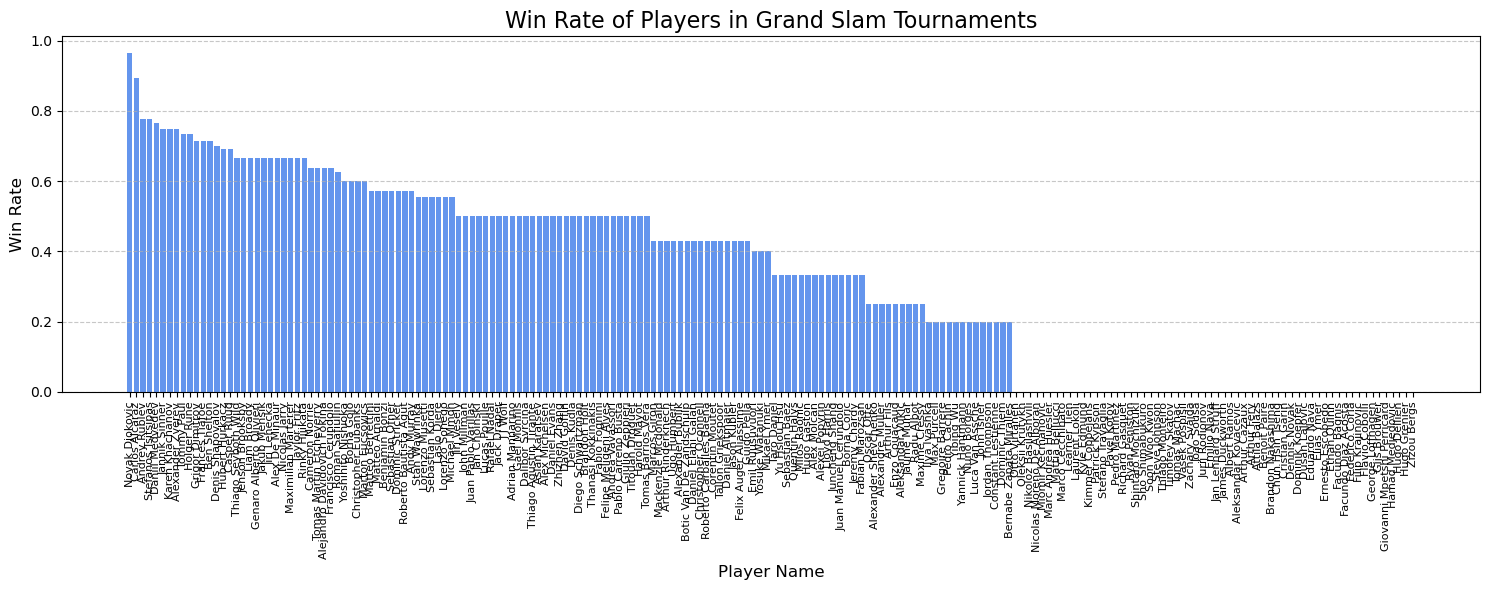

In [10]:
# Make a new df of the probability to win by win_count/game_count
# df_G_p, G means "Grand Slam", "p" means "probability"
df_G_p = df_G_players['win_count'].div(df_G_players['game_count'],axis=0)
df_G_p=pd.DataFrame(df_G_p)
df_G_p.columns=['win_rate']
df_G_p.sort_values(by='win_rate',ascending=False,inplace=True)

# Plot the histogram
plt.figure(figsize=(15, 6))
plt.bar(df_G_p.index, df_G_p['win_rate'], color='#6495ED')
plt.xlabel('Player Name', fontsize=12)
plt.ylabel('Win Rate', fontsize=12)
plt.title('Win Rate of Players in Grand Slam Tournaments', fontsize=16)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

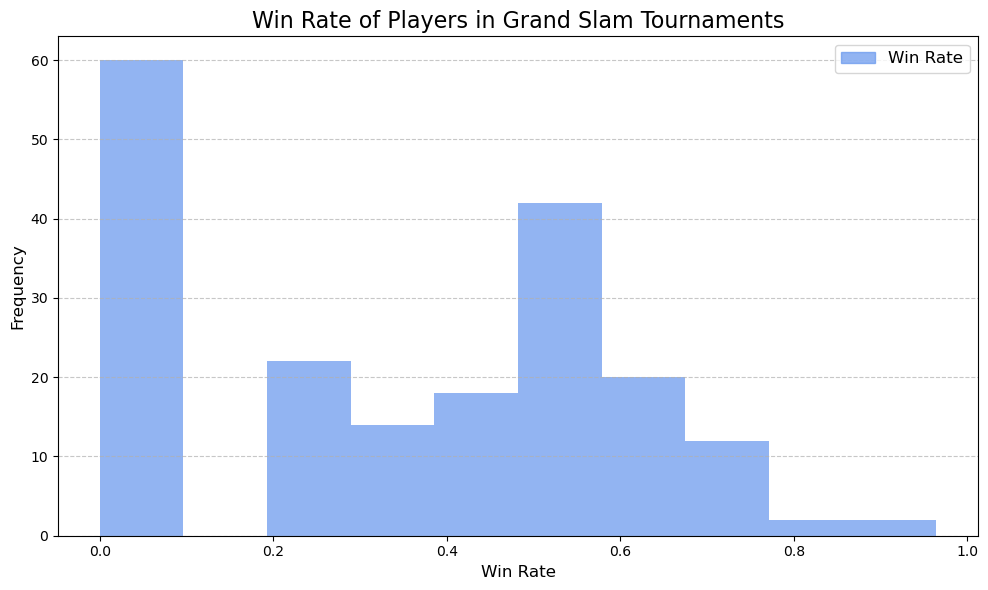

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(df_G_p['win_rate'], bins=10, color='#6495ED', alpha=0.7)
plt.xlabel('Win Rate', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Win Rate of Players in Grand Slam Tournaments', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Create a proxy artist for the legend
proxy = plt.Rectangle((0,0), 1, 1, color='#6495ED', alpha=0.7)

# Add the legend
plt.legend([proxy], ['Win Rate'], loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

About 60% of the players playing do not win a game. 
The majority of players will win half of the games they play, with a 50% win rate among those who can win.
With this being a single elimination game, a 50% win rate indicates that most players will be eliminated in round two.

# <span style="color:#ff0000;font-family">Part 2. Ace and Service Game Wins:</span>

In [11]:
# Set the repository owner and name
owner = 'JeffSackmann'
repo = 'tennis_atp'
# Set the API endpoint
url = f'https://api.github.com/repos/{owner}/{repo}/contents'
# Send a GET request to the API endpoint
response = requests.get(url)
# Get the JSON response
data = response.json()
# Get a list of all files in the repository
files = [item['name'] for item in data if item['type'] == 'file']
# Shrink the list down to all the files of ATP level games after 2010 to 2019
files = [file_name for file_name in files if re.search('atp_matches_201',file_name)]
# Print the head and end of the list of files
print('There are ', len(files), ' files matching the search!')
print(files[1],files[-1])


There are  10  files matching the search!
atp_matches_2011.csv atp_matches_2019.csv


In [12]:
# Get the url of these files
url_atp_matches=["https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/" + file_name for file_name in files]
# and show the first and last urls
url_atp_matches[1],url_atp_matches[-1]

('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2011.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2019.csv')

In [13]:
import pandas as pd
# remember that the DataFrame we have the 10 data files
df_all_games_since_2010_2019 = pd.concat([pd.read_csv(url) for url in url_atp_matches])

In [14]:
# Get all the Grand Slam Games between 2010 to 2019
df_G_games_since_2010_2019 = df_all_games_since_2010_2019.loc[df_all_games_since_2010_2019['tourney_level']=='G',:]

In [15]:
# See the size of our data
len(df_G_games_since_2010_2019)

5080

In [16]:
# See all the columns we have:
df_G_games_since_2010_2019.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

In [17]:
# Get the winners data, change the column names, for concatenation
df_winners_since_2010_2019=df_G_games_since_2010_2019[['winner_id','w_ace','w_SvGms']]
df_winners_since_2010_2019.columns=['player_id','ace','SvGms']
# Get the losers data, change the column names, for concatenation
df_losers_since_2010_2019=df_G_games_since_2010_2019[['loser_id','l_ace','l_SvGms']]
df_losers_since_2010_2019.columns=['player_id','ace','SvGms']
# Concatenate the 2 DataFrames
df_players_since_2010_2019=pd.concat([df_winners_since_2010_2019,df_losers_since_2010_2019],axis=0)
df_players_since_2010_2019

,player_id,ace,SvGms
147,103819,9.0,18.0
148,103812,6.0,16.0
149,103565,3.0,17.0
150,103656,4.0,8.0
151,103720,10.0,12.0
...,...,...,...
2175,104792,10.0,24.0
2176,106043,4.0,15.0
2177,105777,2.0,16.0
2178,126610,9.0,16.0


In [18]:
df_players_wins_since_2010_2019=df_winners_since_2010_2019.groupby('player_id').count()[['ace',]]
# change the colume names
df_players_wins_since_2010_2019.columns=['win_count']

df_players_loses_since_2010_2019=df_losers_since_2010_2019.groupby('player_id').count()[['ace',]]
# change the colume names
df_players_loses_since_2010_2019.columns=['lose_count']

df_players_stats=pd.concat([df_players_wins_since_2010_2019,df_players_loses_since_2010_2019],axis=1,join='outer').fillna(0)
# and then find the sum of win and los and add to the 3rd column
df_players_stats=pd.concat([df_players_stats,df_players_stats.sum(axis=1)],axis=1)
# rename the 3rd columns
df_players_stats.columns=['win_count','los_count','game_count']
df_players_stats

,win_count,los_count,game_count
player_id,,,
100644,32.0,18,50.0
102783,3.0,7,10.0
102905,2.0,2,4.0
102967,1.0,9,10.0
103096,6.0,8,14.0
...,...,...,...
200484,0.0,2,2.0
200516,0.0,1,1.0
206173,0.0,1,1.0


In [19]:
win_aces = df_winners_since_2010_2019.groupby('player_id').median()
win_aces.columns=['win_aces_m','win_SvGms_m']

loss_aces = df_losers_since_2010_2019.groupby('player_id').median()
loss_aces.columns=['loss_aces_m','loss_SvGms_m']

total_win_aces = df_winners_since_2010_2019.groupby('player_id').sum()
total_win_aces.columns=['total_win_aces','total_win_SvGms_m']

total_lose_aces = df_losers_since_2010_2019.groupby('player_id').sum()
total_lose_aces.columns=['total_loss_aces_m','total_loss_SvGms_m']

df_players_stats= pd.concat([df_players_stats,win_aces],axis=1,join='outer').fillna(0.0)

df_players_stats= pd.concat([df_players_stats,loss_aces],axis=1,join='inner').fillna(0.0)

df_players_stats= pd.concat([df_players_stats,total_win_aces],axis=1,join='outer').fillna(0.0)

df_players_stats= pd.concat([df_players_stats,total_lose_aces],axis=1,join='inner').fillna(0.0)

df_players_stats['win_aces_m'] = df_players_stats['win_aces_m'].replace(0.0, 0.01)
df_players_stats['win_SvGms_m'] = df_players_stats['win_SvGms_m'].replace(0.0, 0.01)
df_players_stats['loss_aces_m'] = df_players_stats['loss_aces_m'].replace(0.0, 0.01)
df_players_stats['loss_SvGms_m'] = df_players_stats['loss_SvGms_m'].replace(0.0, 0.01)

df_players_stats['total_win_aces'] = df_players_stats['total_win_aces'].replace(0.0, 0.01)
df_players_stats['total_win_SvGms_m'] = df_players_stats['total_win_SvGms_m'].replace(0.0, 0.01)
df_players_stats['total_loss_aces_m'] = df_players_stats['total_loss_aces_m'].replace(0.0, 0.01)
df_players_stats['total_loss_SvGms_m'] = df_players_stats['total_loss_SvGms_m'].replace(0.0, 0.01)

In [20]:
df_players_stats

,win_count,los_count,game_count,win_aces_m,win_SvGms_m,loss_aces_m,loss_SvGms_m,total_win_aces,total_win_SvGms_m,total_loss_aces_m,total_loss_SvGms_m
player_id,,,,,,,,,,,
100644,32.0,18,50.0,11.00,18.50,8.5,20.0,426.00,602.00,198.0,345.0
102783,3.0,7,10.0,2.00,15.00,5.0,17.0,5.00,45.00,30.0,127.0
102905,2.0,2,4.0,11.00,19.00,2.0,12.5,22.00,38.00,4.0,25.0
102967,1.0,9,10.0,14.00,17.00,7.0,14.0,14.00,17.00,48.0,131.0
103096,6.0,8,14.0,7.50,20.00,5.0,22.0,59.00,117.00,44.0,167.0
...,...,...,...,...,...,...,...,...,...,...,...
200484,0.0,2,2.0,0.01,0.01,10.5,18.5,0.01,0.01,21.0,37.0
200516,0.0,1,1.0,0.01,0.01,4.0,14.0,0.01,0.01,4.0,14.0
206173,0.0,1,1.0,0.01,0.01,2.0,19.0,0.01,0.01,2.0,19.0


In [21]:
df_players_stats[df_players_stats.index.duplicated()]

,win_count,los_count,game_count,win_aces_m,win_SvGms_m,loss_aces_m,loss_SvGms_m,total_win_aces,total_win_SvGms_m,total_loss_aces_m,total_loss_SvGms_m
player_id,,,,,,,,,,,


In [22]:
# Your calculation for the wins aces factor
wins_aces_factor = (df_players_stats['win_aces_m'] * (df_players_stats['win_count'] / df_players_stats['game_count'])) / ((df_players_stats['win_aces_m'] * (df_players_stats['win_count'] / df_players_stats['game_count'])) + (df_players_stats['loss_aces_m'] * (df_players_stats['los_count'] / df_players_stats['game_count'])))

# Create a DataFrame from the calculated values
df_players_winrate_ace = pd.DataFrame(wins_aces_factor, columns=['wins_aces_factor'])

# Sort the DataFrame by index in descending order
df_players_winrate_ace.sort_index(ascending=False, inplace=True)

# Uncomment and modify the next line if you wish to replace zero values with a small non-zero value
df_players_winrate_ace.replace(0.000000, 0.000001, inplace=True)


In [23]:
df_players_winrate_df=pd.DataFrame(((df_players_stats['win_SvGms_m'] * (df_players_stats['win_count']/df_players_stats['game_count']))/((df_players_stats['win_SvGms_m'] * (df_players_stats['win_count']/df_players_stats['game_count']))+(df_players_stats['loss_SvGms_m'] * (df_players_stats['los_count']/df_players_stats['game_count'])))))
df_players_winrate_df.columns=['wins_SvGms_factor']
df_players_winrate_df.sort_index(ascending=False, inplace=True)
df_players_winrate_df.replace(0.000000, 0.000001)

,wins_SvGms_factor
player_id,
208260,0.000001
206703,0.000001
206173,0.000001
202385,0.333333
200615,0.517766
...,...
102845,0.000001
102839,0.000001
102783,0.274390


In [24]:
df_players_stats= pd.concat([df_players_stats,df_players_winrate_ace],axis=1,join='inner')

df_players_stats= pd.concat([df_players_stats,df_players_winrate_df],axis=1,join='inner')
df_players_stats.replace(0.000000, 0.000001)
df_players_stats

,win_count,los_count,game_count,win_aces_m,win_SvGms_m,loss_aces_m,loss_SvGms_m,total_win_aces,total_win_SvGms_m,total_loss_aces_m,total_loss_SvGms_m,wins_aces_factor,wins_SvGms_factor
player_id,,,,,,,,,,,,,
100644,32.0,18,50.0,11.00,18.50,8.5,20.0,426.00,602.00,198.0,345.0,0.697030,0.621849
102783,3.0,7,10.0,2.00,15.00,5.0,17.0,5.00,45.00,30.0,127.0,0.146341,0.274390
102905,2.0,2,4.0,11.00,19.00,2.0,12.5,22.00,38.00,4.0,25.0,0.846154,0.603175
102967,1.0,9,10.0,14.00,17.00,7.0,14.0,14.00,17.00,48.0,131.0,0.181818,0.118881
103096,6.0,8,14.0,7.50,20.00,5.0,22.0,59.00,117.00,44.0,167.0,0.529412,0.405405
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200484,0.0,2,2.0,0.01,0.01,10.5,18.5,0.01,0.01,21.0,37.0,0.000001,0.000000
200516,0.0,1,1.0,0.01,0.01,4.0,14.0,0.01,0.01,4.0,14.0,0.000001,0.000000
206173,0.0,1,1.0,0.01,0.01,2.0,19.0,0.01,0.01,2.0,19.0,0.000001,0.000000


In [25]:
df_players_winrate_avg=pd.DataFrame((df_players_stats['wins_aces_factor']+df_players_stats['wins_SvGms_factor'])/2).replace(0.000000, 0.000001)
df_players_winrate_avg.columns=['wins_rate']
df_players_winrate_avg.sort_index(ascending=False, inplace=True)
df_players_winrate_avg

,wins_rate
player_id,
208260,5.000000e-07
206703,5.000000e-07
206173,5.000000e-07
202385,3.809524e-01
200615,6.273043e-01
...,...
102845,5.000000e-07
102839,5.000000e-07
102783,2.103659e-01


***Too many*** of them exist. We attempted to simulate each of these players, but it took longer than an hour to complete. 
We made the decision to narrow down the player list to just include those who signed up for the 2023 Australian Open.

In [26]:
url_atp_matches_2023="https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2023.csv"
df_single_2023 = pd.read_csv(url_atp_matches_2023)
df_winners_2023 = df_single_2023.loc[df_single_2023['tourney_level']=='G',['winner_name','winner_id']]
df_winners_2023.columns=['name','id']
df_losers_2023 = df_single_2023.loc[df_single_2023['tourney_level']=='G',['loser_name','loser_id']]
df_losers_2023.columns=['name','id']
df_winner_loser_2023 = pd.concat([df_losers_2023,df_winners_2023],axis=0)
df_players_names_2023 = df_winner_loser_2023.groupby('id').max()
df_players_names_2023

,name
id,
100644,Alexander Zverev
104527,Stan Wawrinka
104545,John Isner
104745,Rafael Nadal
104755,Richard Gasquet
...,...
210097,Ben Shelton
210150,Jakub Mensik
210319,Ethan Quinn


In [29]:
import math

df_players_2023=pd.concat([df_players_names_2023,df_players_winrate_avg],axis=1,join='inner')
#df_players_2023=pd.concat([df_players_2023,df_players_stats[['win_aces_m','win_df_m','loss_aces_m','loss_df_m']]],axis=1,join='inner')
df_players_2023=pd.concat([df_players_2023,df_players_stats[['win_aces_m','win_SvGms_m']]],axis=1,join='inner')
df_players_2023.sort_values(by='wins_rate',ascending=False, inplace=True)
df_players_2023['wins_rate']=[math.floor(i) for i in df_players_2023['wins_rate']*7]
df_players_2023['wins_rate'] = [0.01 if x == 0 else x for x in df_players_2023['wins_rate']]
df_players_2023

,name,wins_rate,win_aces_m,win_SvGms_m
104925,Novak Djokovic,6.00,6.00,15.00
104745,Rafael Nadal,6.00,4.00,14.00
124116,Sebastian Ofner,5.00,9.50,17.50
104918,Andy Murray,5.00,9.00,15.00
136440,Dominik Koepfer,5.00,10.50,20.00
...,...,...,...,...
106331,Christopher Oconnell,0.01,0.01,0.01
106293,Kimmer Coppejans,0.01,0.01,0.01
106218,Marcos Giron,0.01,0.01,0.01
105870,Yannick Hanfmann,0.01,0.01,0.01


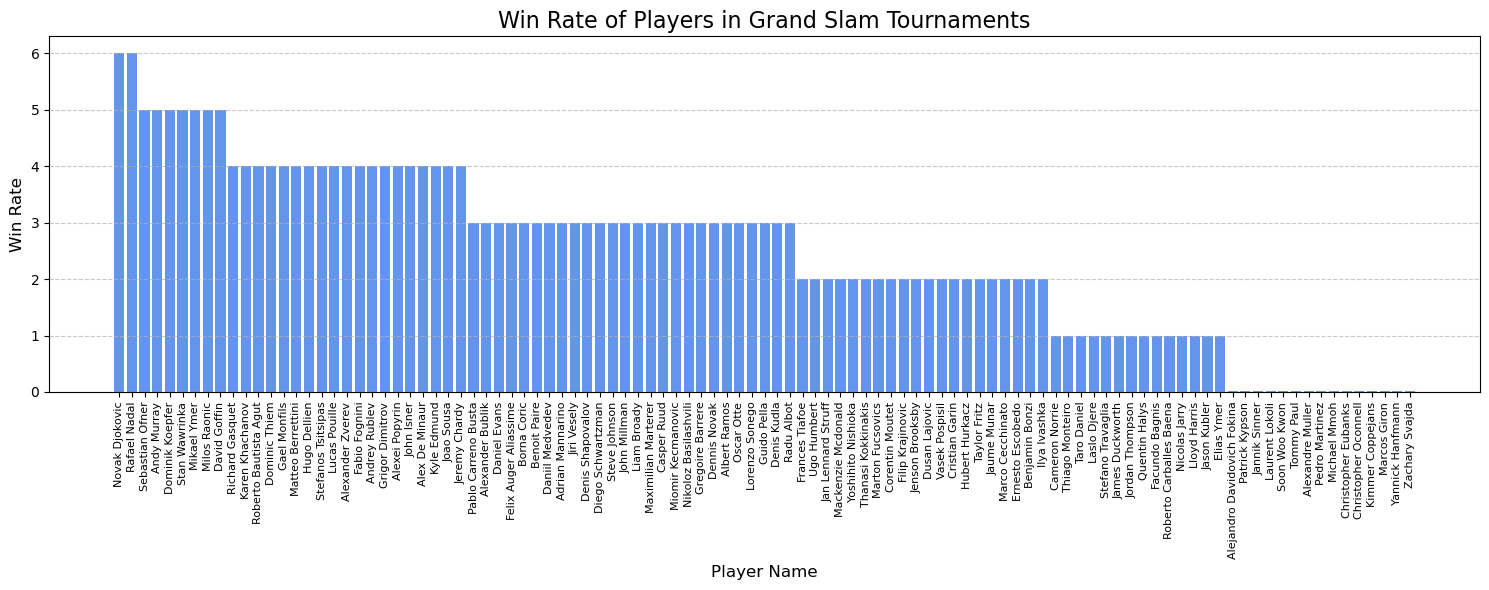

In [30]:
# Set the figure size
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the bar chart
ax.bar(df_players_2023['name'], df_players_2023['wins_rate'], color='#6495ED')

# Set the x and y labels and the title
ax.set_xlabel('Player Name', fontsize=12)
ax.set_ylabel('Win Rate', fontsize=12)
ax.set_title('Win Rate of Players in Grand Slam Tournaments', fontsize=16)

# Rotate the x-axis labels and adjust their font size
plt.xticks(rotation=90, fontsize=8)

# Adjust the font size of the y-axis labels
plt.yticks(fontsize=10)

# Add horizontal grid lines and adjust their transparency
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


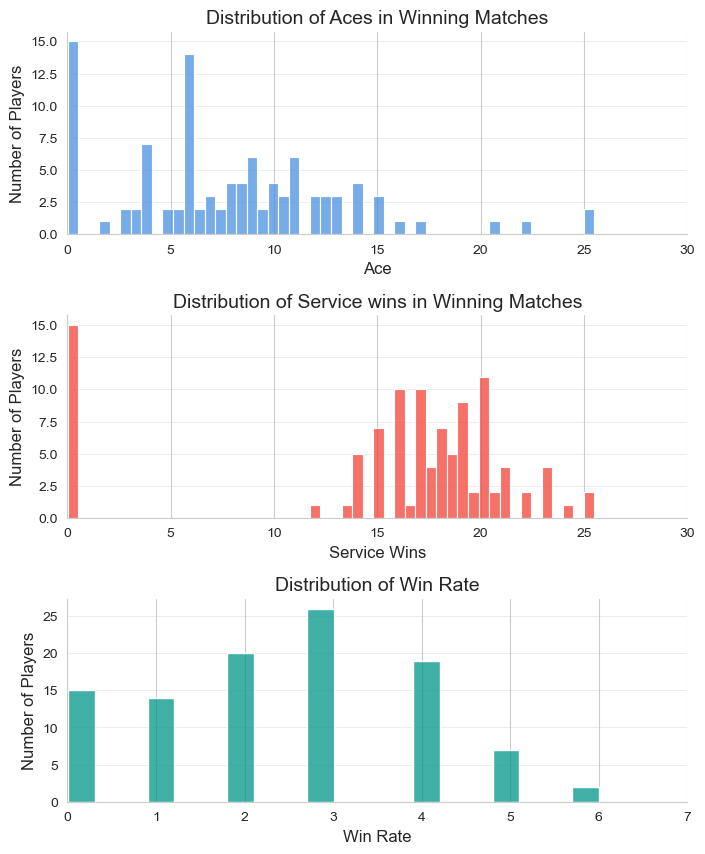

In [31]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Create the figure and subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))

# Set colors
colors = ['#4a90e2', '#f44336', '#009688']

# Plot the histograms
sns.histplot(data=df_players_2023, x='win_aces_m', bins=50, ax=axs[0], color=colors[0])
sns.histplot(data=df_players_2023, x='win_SvGms_m', bins=50, ax=axs[1], color=colors[1])
sns.histplot(data=df_players_2023, x='wins_rate', bins=20, ax=axs[2], color=colors[2])

# Set the x-limits
axs[0].set_xlim([0, 30])
axs[1].set_xlim([0, 30])
axs[2].set_xlim([0, 7])

# Set the titles and labels
axs[0].set_title('Distribution of Aces in Winning Matches', fontsize=14)
axs[0].set_xlabel('Ace', fontsize=12)
axs[0].set_ylabel('Number of Players', fontsize=12)

axs[1].set_title('Distribution of Service wins in Winning Matches', fontsize=14)
axs[1].set_xlabel('Service Wins', fontsize=12)
axs[1].set_ylabel('Number of Players', fontsize=12)

axs[2].set_title('Distribution of Win Rate', fontsize=14)
axs[2].set_xlabel('Win Rate', fontsize=12)
axs[2].set_ylabel('Number of Players', fontsize=12)

# Remove the top and right spines
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add a horizontal grid to each plot
for ax in axs:
    ax.yaxis.grid(True, linestyle='-', linewidth=0.5, alpha=0.5)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Show the plot
plt.show()

# <span style="color:#ff0000;font-family">Part 3. Four Factor Analysis:</span>

### For more data, we merged 2000~2023 dataset to one dataframe.

In [27]:
# Now try to read all the data since 2000, for a better statistics of these 128 players.
# Set the repository owner and name
owner = 'JeffSackmann'
repo = 'tennis_atp'
# Set the API endpoint
url = f'https://api.github.com/repos/{owner}/{repo}/contents'
# Send a GET request to the API endpoint
response = requests.get(url)
# Get the JSON response
data = response.json()
# Get a list of all files in the repository
files = [item['name'] for item in data if item['type'] == 'file']
# Shrink the list down to all the files of ATP level games after 2000
files = [file_name for file_name in files if re.search('atp_matches_20',file_name)]
# Print the head and end of the list of files
print('There are ', len(files), ' files matching the search!')
print(files[1],files[-1])



There are  24  files matching the search!
atp_matches_2001.csv atp_matches_2023.csv


In [53]:
# Get the url of these files
url_atp_matches=["https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/" + file_name for file_name in files]
# and show the first and last urls
url_atp_matches[1],url_atp_matches[-1]

('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2001.csv',
 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2023.csv')

In [28]:
# Build a huge data frame of all the games since 2000
df_single_G_since_2000 = pd.concat([pd.read_csv(url) for url in url_atp_matches])

In [29]:
# check out the huge data frame: df_single_G_since_2000
len(df_single_G_since_2000)

71800

In [30]:
# narrow down to all the G level games
df_single_G_since_2000 = df_single_G_since_2000.loc[df_single_G_since_2000["tourney_level"]=='G',:]
df_single_G_since_2000 = df_single_G_since_2000[['tourney_id', 'tourney_date','winner_id','winner_name','winner_rank','w_1stWon','w_2ndWon','w_ace','w_1stIn']]
# check the size again
df_single_G_since_2000

,tourney_id,tourney_date,winner_id,winner_name,winner_rank,w_1stWon,w_2ndWon,w_ace,w_1stIn
2130,2000-520,20000529,101736,Andre Agassi,1.0,49.0,19.0,8.0,67.0
2131,2000-520,20000529,102344,Karol Kucera,40.0,27.0,13.0,11.0,38.0
2132,2000-520,20000529,103181,Jiri Vanek,88.0,66.0,34.0,9.0,94.0
2133,2000-520,20000529,102644,Franco Squillari,45.0,37.0,25.0,2.0,56.0
2134,2000-520,20000529,103454,Nicolas Massu,75.0,30.0,23.0,5.0,45.0
...,...,...,...,...,...,...,...,...,...
2268,2023-560,20230828,210097,Ben Shelton,47.0,49.0,22.0,14.0,64.0
2269,2023-560,20230828,104925,Novak Djokovic,2.0,39.0,21.0,7.0,57.0
2270,2023-560,20230828,106421,Daniil Medvedev,3.0,68.0,23.0,9.0,83.0
2271,2023-560,20230828,104925,Novak Djokovic,2.0,56.0,11.0,5.0,67.0


In [31]:
players = set(df_single_G_since_2000['winner_name'].values.tolist())
players

## total 670 players won in last 23 years, their name as below:

{'Adam Pavlasek',
 'Adrian Mannarino',
 'Adrian Menendez Maceiras',
 'Adrian Ungur',
 'Adrian Voinea',
 'Agustin Calleri',
 'Aisam Ul Haq Qureshi',
 'Alastair Gray',
 'Albert Costa',
 'Albert Montanes',
 'Albert Portas',
 'Albert Ramos',
 'Alberto Martin',
 'Alejandro Davidovich Fokina',
 'Alejandro Falla',
 'Alejandro Gonzalez',
 'Alejandro Tabilo',
 'Aleksandar Vukic',
 'Aleksandr Nedovyesov',
 'Alessandro Giannessi',
 'Alessio Di Mauro',
 'Alex Bogomolov Jr',
 'Alex Bolt',
 'Alex Calatrava',
 'Alex Corretja',
 'Alex De Minaur',
 'Alex Kim',
 'Alex Kuznetsov',
 'Alex Michelsen',
 'Alex Molcan',
 'Alex Obrien',
 'Alexander Bublik',
 'Alexander Kudryavtsev',
 'Alexander Peya',
 'Alexander Popp',
 'Alexander Shevchenko',
 'Alexander Waske',
 'Alexander Zverev',
 'Alexandr Dolgopolov',
 'Alexandre Muller',
 'Alexandre Simoni',
 'Alexei Popyrin',
 'Aljaz Bedene',
 'Alun Jones',
 'Amer Delic',
 'Amir Hadad',
 'Amir Weintraub',
 'Andre Agassi',
 'Andre Sa',
 'Andrea Arnaboldi',
 'Andrea Gau

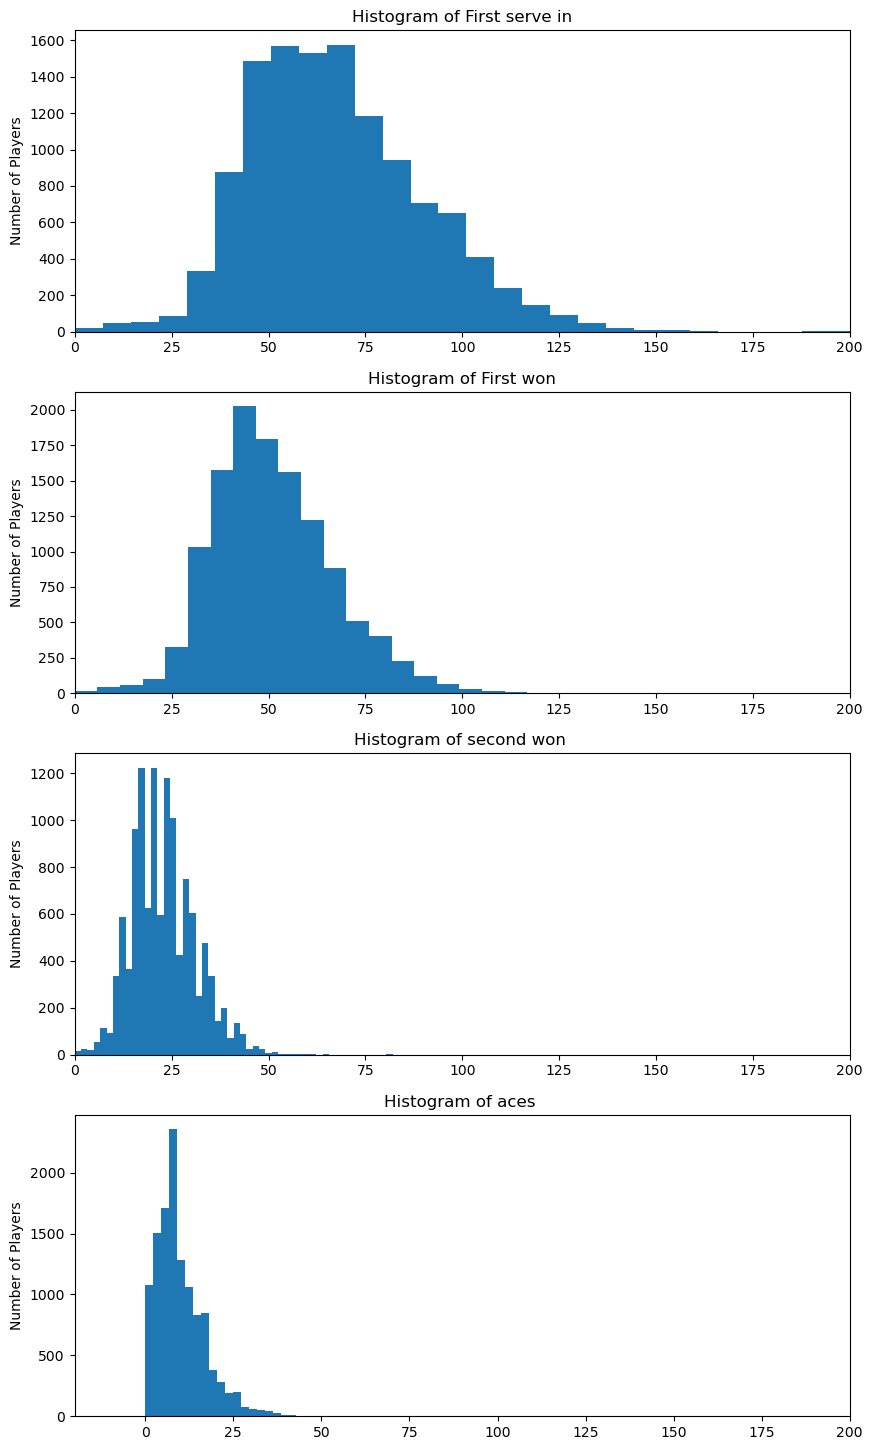

In [32]:
# Let's take a look at the distribution of ace, dft and win_rate
# Create the figure
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(10,18))

# Plot the histograms
ax[0].hist(df_single_G_since_2000["w_1stIn"], bins=50)
ax[1].hist(df_single_G_since_2000['w_1stWon'], bins=50)
ax[2].hist(df_single_G_since_2000['w_2ndWon'], bins=50)
ax[3].hist(df_single_G_since_2000['w_ace'], bins=50)
#ax[4].hist(df_single_G_since_2000['win_rate'], bins=50)

# Set the x-limits
ax[0].set_xlim([0, 200])
ax[1].set_xlim([0, 200])
ax[2].set_xlim([0, 200])
ax[3].set_xlim([-20, 200])
#ax[4].set_xlim([0, 7])


# Set the titles and labels
ax[0].set_title('Histogram of First serve in')
#ax[0].set_xlabel('1stIn')
ax[0].set_ylabel('Number of Players')

ax[1].set_title('Histogram of First won')
#ax[1].set_xlabel('1stWon')
ax[1].set_ylabel('Number of Players')

ax[2].set_title('Histogram of second won ')
#ax[2].set_xlabel('2ndWon')
ax[2].set_ylabel('Number of Players')

ax[3].set_title('Histogram of aces ')
#ax[3].set_xlabel('bpSavedRate')
ax[3].set_ylabel('Number of Players')

#ax[4].set_title('Histogram of historic win rate ')
#ax[4].set_xlabel('win rate')
#ax[4].set_ylabel('Number of Players')

fig.figsize=(28, 7)
# Show the plot
plt.show()


A slight skew distribution is seen in the 'w_1stIn' histogram.</br>
In the 'w_1stWon' histogram, the distribution is normal.</br>
The 'w_2ndWon' histogram appears abnormal because it displays a distribution with all values greater than 0. </br>
The histogram of the 'w_ace' exhibits a slight skewness.


## Which factors will impact the winner rank? Is it positive or negative？

### If a player finished a game, his rank increased (winner_rank value decreased), we set it as 1
### If a player finished a game, his rank decreased (winner_rank value decreased), we set it as 0



In [33]:
all_data = []
for player in players:
    df = df_single_G_since_2000[df_single_G_since_2000['winner_name'] == player].values.tolist()
    df = sorted(df, key = lambda x:x[1])
    prev = []
    for i in range(len(df)):
        if len(prev) == 0 or prev[-1][1] == df[i][1]:
            prev.append(df[i])
        else:
            for game in prev:
                all_data.append(game + [int(game[4] > df[i][4])])
            prev = [df[i]]
all_data = pd.DataFrame(all_data, columns=df_single_G_since_2000.columns.tolist() + ['Rank Improved After this game'])

This is the key point, data analyze and create a new dataset by added a column'Rank Improved After this game' (0,1)

In [35]:
# Normailized parameter and dropped NA
for field in ['w_1stWon', 'w_2ndWon', 'w_ace', 'w_1stIn']:
    all_data[field] = (all_data[field] - np.mean(all_data[field])) / np.std(all_data[field])
all_data = all_data.dropna()
all_data.head(10)

,tourney_id,tourney_date,winner_id,winner_name,winner_rank,w_1stWon,w_2ndWon,w_ace,w_1stIn,Rank Improved After this game
0,2005-580,20050117,103193,Peter Wessels,91.0,-0.762314,-0.478614,-0.153714,-0.990909,1
1,2005-520,20050523,103193,Peter Wessels,82.0,-1.017292,-0.845917,-0.576313,-1.080665,0
2,2000-520,20000529,103428,Juan Ignacio Chela,56.0,-0.124869,1.970069,-0.717179,0.131046,0
3,2001-580,20010115,103428,Juan Ignacio Chela,64.0,0.640065,0.378425,0.409751,0.579828,1
4,2001-580,20010115,103428,Juan Ignacio Chela,64.0,-0.698570,-0.723483,-0.153714,-0.497249,1
5,2002-580,20020114,103428,Juan Ignacio Chela,55.0,-0.061124,0.133557,-0.435446,0.265681,1
6,2002-560,20020826,103428,Juan Ignacio Chela,24.0,-0.953548,0.011122,-0.717179,-0.542127,0
7,2002-560,20020826,103428,Juan Ignacio Chela,24.0,-0.443591,0.623293,-1.139778,-0.317736,0
8,2002-560,20020826,103428,Juan Ignacio Chela,24.0,-0.762314,0.133557,-0.858045,-0.497249,0
9,2003-580,20030113,103428,Juan Ignacio Chela,26.0,-0.316102,0.011122,-0.717179,-0.362614,0


We use a Bernoulli data likelihood to model rank increase or decrease for the dataset from 2000 to 2023. 
Bernoulli is conditioned on a single probability factor, the probability of winning a game.

We will model that factor as a linear regression of the *four factors*, which will allow us to compare (by evaluating computationally their coefficients) how important each of these four factors are in determing the winner rank. 

In [36]:
with pm.Model() as tennis_regression_model:
    w_1stWon = pm.Data("w_1stWon", all_data["w_1stWon"])
    w_2ndWon = pm.Data("w_2ndWon", all_data["w_2ndWon"])
    w_ace = pm.Data("w_ace", all_data["w_ace"])
    w_1stIn = pm.Data("w_1stIn", all_data["w_1stIn"])
    
    # priors
    beta_i = pm.Normal("beta_i", 0, 1)
    beta_1stWon = pm.Normal("beta_1stWon", 0, 1)
    beta_2ndWon = pm.Normal("beta_2ndWon", 0, 1)
    beta_ace = pm.Normal("beta_ace", 0, 1)
    beta_1stIn = pm.Normal("beta_1stIn", 0, 1)
    
    #beta_i = pm.Normal("beta_i", 0, 1)
    #beta_1stWon = pm.Beta("beta_1stWon", 1, 1)
    #beta_2ndWon = pm.Beta("beta_2ndWon", 1, 1)
    #beta_ace = pm.Beta("beta_ace", 1, 1)
    #beta_1stIn = pm.Beta("beta_1stIn", 1, 1)
    
    # linear model
    mu = beta_i + beta_1stWon * w_1stWon + beta_2ndWon * w_2ndWon + beta_ace * w_ace + beta_1stIn * w_1stIn
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    
    # likelihood
    pm.Bernoulli("Rank Improved After this game", p=p, observed=all_data["Rank Improved After this game"])

/Users/xingxingxiao/anaconda3/lib/python3.11/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [ ]:
pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


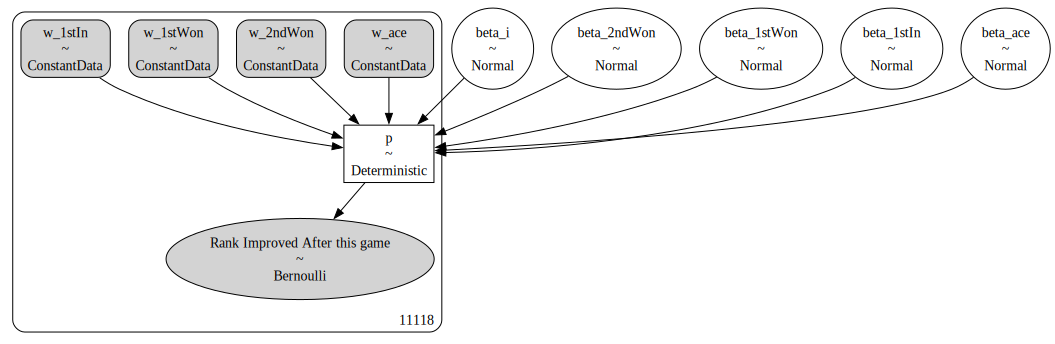

In [37]:
pm.model_to_graphviz(tennis_regression_model)

In [38]:
with tennis_regression_model:
    cdata = pm.sample(1000, tune=2000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_i, beta_1stWon, beta_2ndWon, beta_ace, beta_1stIn]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 47 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


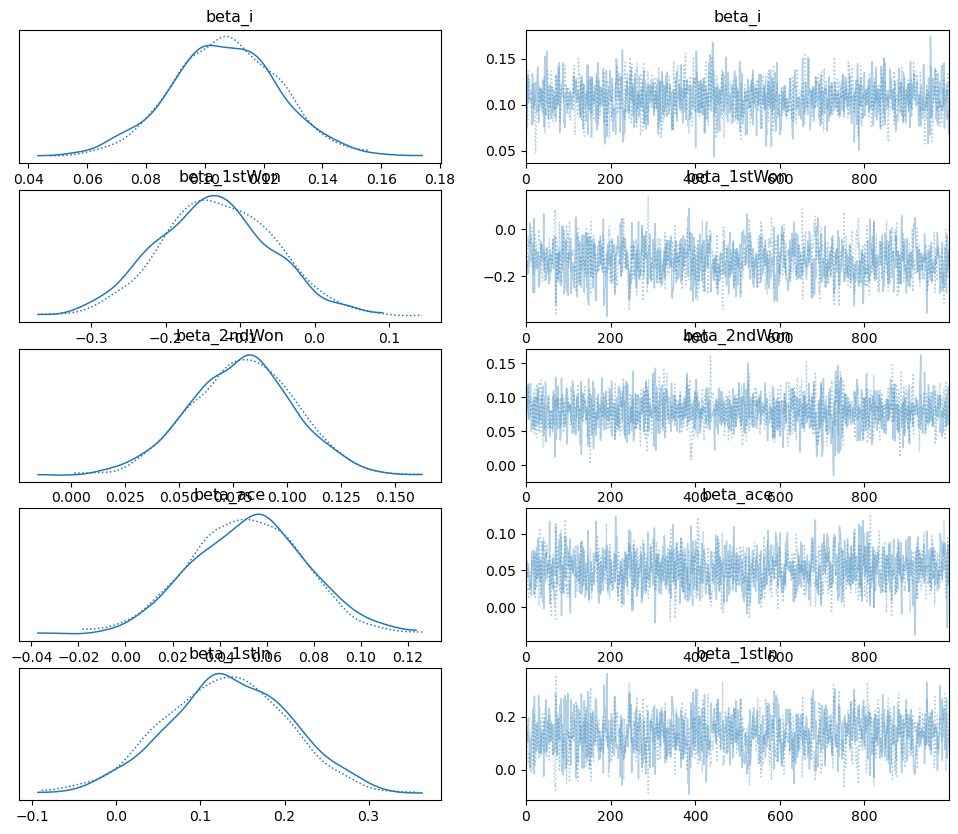

In [ ]:
az.plot_trace(cdata, var_names=['beta_i', 'beta_1stWon', 'beta_2ndWon', 'beta_ace', 'beta_1stIn']);

In [39]:
Summary=az.summary(cdata, round_to=2)
Summary[0:5]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_i,0.11,0.02,0.07,0.14,0.0,0.0,1565.20,1188.33,1.0
beta_1stWon,-0.13,0.08,-0.28,0.01,0.0,0.0,621.79,1280.82,1.0
beta_2ndWon,0.08,0.02,0.04,0.12,0.0,0.0,1881.02,1274.76,1.0
beta_ace,0.05,0.03,-0.00,0.10,0.0,0.0,958.51,1070.54,1.0
beta_1stIn,0.13,0.08,-0.02,0.26,0.0,0.0,630.66,894.57,1.0


<Axes: >

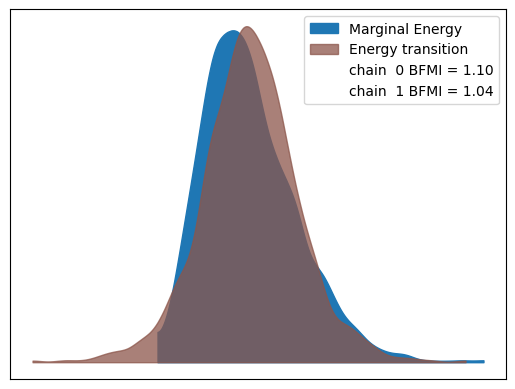

In [40]:
az.plot_energy(cdata)

Sampling: [Rank Improved After this game, beta_1stIn, beta_1stWon, beta_2ndWon, beta_ace, beta_i]
Sampling: [Rank Improved After this game]


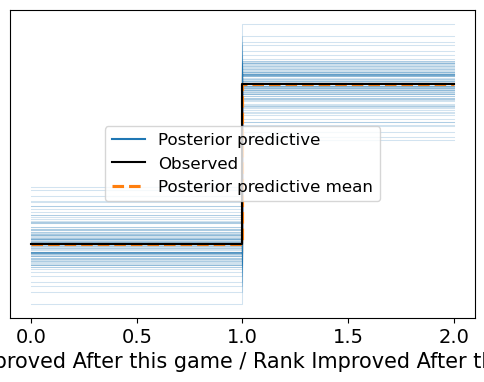

In [41]:
with tennis_regression_model:
    # prior analysis
    prior_pc = pm.sample_prior_predictive()

    # posterior predictive
    ppc = pm.sample_posterior_predictive(   trace=cdata,
                                            random_seed=1,
                                            extend_inferencedata=True
                                              )
    fig, ax = plt.subplots(figsize=(6,4))
    az.plot_ppc(data=ppc, num_pp_samples=100, group='posterior', ax=ax);
    #ax.axvline(np.mean(target), ls="--", color="r", label="True mean")
    ax.legend(fontsize=12);

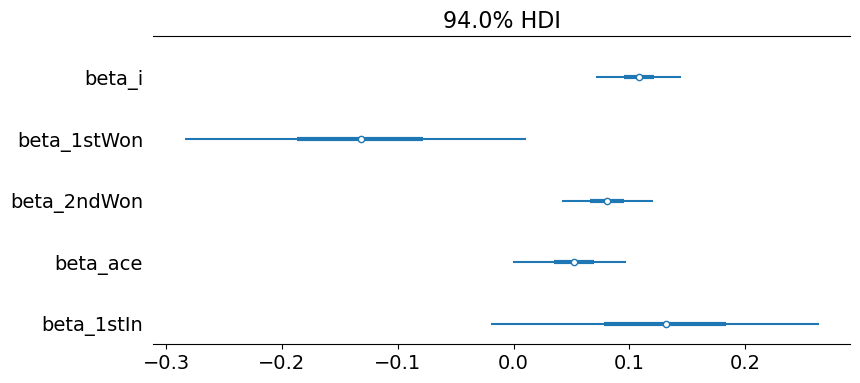

In [42]:
with tennis_regression_model:
    az.plot_forest(cdata, var_names=['beta_i', 'beta_1stWon', 'beta_2ndWon', 'beta_ace', 'beta_1stIn'], combined=True, figsize=(9,4))

    

This weight and corelation study shows that **‘1stln’** (The number of first serves in by the winner of the match) is the key to let player rank increase! And **2ndWon**(The number of first serves won by the winner of the match) and **ace**(The number of aces served by the winner of the match) show slightly improve to the winner rank.

It's way more imprtant than any other facts in the game!
Another important fact is to get the point on the 1st play. That requires the players to be more aggressive than conservative!

# Conclusion
    As for the tennis players, based on Baysian Model, the 4 factors we were studied:

    1. the 4 factors have an influence on the winner rank imcrease, especially 'beta_1stln' having the strongest influence, and other 2 factors(beta_2ndWon and beta_ace) have slightly influence. beta_1stWon has negative influence.
    
    2. Overall, the four factors have a positive impact on a player's winner rank.
    


## Bibliography


#### about Data Science </br>
requests 2.28.2 </br>
https://pypi.org/project/requests/ </br>

re — Regular expression operations</br>
https://docs.python.org/3/library/re.html</br>

Exploratory Data Analysis with R    
https://medium.com/@tobikasali/exploratory-data-analysis-with-r-f0b0a5163ecd     


Utilizing Data to Predict Winners of Tennis Matches    
https://nycdatascience.com/blog/student-works/utilizing-data-to-predict-winners-of-tennis-matches/     

Adult Tournament Information   
https://www.usta.com/en/home/play/adult-tennis/programs/eastern/adult-tennis-tournament-information-and-regulations.html    

pandas.merge_asof    
https://pandas.pydata.org/docs/reference/api/pandas.merge_asof.html    


pymc.ZeroInflatedBinomial    
https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.ZeroInflatedBinomial.html    

statsmodels    
https://www.statsmodels.org/stable/index.html    


#### about Tennis</br>

Sackmann, J. (n.d.). tennis_atp [Computer software]. GitHub. </br>
https://github.com/JeffSackmann/tennis_atp</br>

JeffSackmann/tennis_atp/matches_data_dictionary.txt</br>
https://github.com/JeffSackmann/tennis_atp/blob/master/matches_data_dictionary.txt</br>

Welcome to US Open 101: a USOpen.org guide to how tennis works.</br>
https://www.usopen.org/en_US/us-open-at-home/how_tennis_works_us_open_101.html</br>

Wimbledon tennis tournament canceled amid coronavirus pandemic</br>
https://www.cnn.com/2020/04/01/tennis/wimbledon-canceled-coronavirus-2020-spt-intl/index.html</br>

Novak Djokovic knocked out of Wimbledon by Sam Querrey</br>
https://www.theguardian.com/sport/2016/jul/02/novak-djokovic-knocked-out-wimbledon-sam-querrey</br>

A Data Model to Track Tennis Tournaments </br>
https://vertabelo.com/blog/a-data-model-to-track-tennis-tournaments/</br>